<a href="https://colab.research.google.com/github/AbhishekPatwardhan/Project_/blob/main/Natural_Language_Processing_with_Disaster_Tweets_Predict_.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Natural Language Processing is a branch of AI that enables the computers to understand,generate and manipulate human Languages.

Great Resource regarding NLP:-https://www.analyticsvidhya.com/blog/2022/03/a-brief-overview-of-recurrent-neural-networks-rnn

# Problem Statement: Natural Language Processing with Disaster Tweets.
## Predict which Tweets are about real disasters and which ones are not


All the train test dataset is downloaded from kaggle:-https://www.kaggle.com/competitions/nlp-getting-started

Basic workflow of our model would be:

Text -> turn into numbers -> build a model -> train the model to find patterns -> use patterns (make predictions)

# Dataset

In [ ]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-08-30 12:08:40--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.1’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0.001s  

2023-08-30 12:08:40 (14.9 MB/s) - ‘helper_functions.py.1’ saved [10246/10246]



#Helper functions.

In [ ]:
# Import series of helper functions for the notebook
from helper_functions import unzip_data, create_tensorboard_callback, plot_loss_curves, compare_historys,calculate_results

In [ ]:
# Download data (same as from Kaggle)
!wget "https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip"

--2023-08-30 12:08:41--  https://storage.googleapis.com/ztm_tf_course/nlp_getting_started.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.135.128, 74.125.142.128, 173.194.202.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.135.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 607343 (593K) [application/zip]
Saving to: ‘nlp_getting_started.zip’

nlp_getting_started 100%[===================>] 593.11K  --.-KB/s    in 0.01s   

2023-08-30 12:08:41 (53.9 MB/s) - ‘nlp_getting_started.zip’ saved [607343/607343]



In [ ]:
unzip_data("nlp_getting_started.zip")

In [ ]:
# Visualizing a text dataset
import pandas as pd

train_df=pd.read_csv('train.csv')
test_df=pd.read_csv('test.csv')

In [ ]:
train_df.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


In [ ]:
train_df_shuffled=train_df.sample(frac=1,random_state=42)

In [ ]:
# Check if the dataset is balanced or not
train_df.target.value_counts()

0    4342
1    3271
Name: target, dtype: int64

Now we will split the train dataset into tarin and validation dataset.This practice will help us to understand the False Predictions of our model.
Rather than directly testing it on test dataset we will test it on validation data correct the errors & then go for the test data.

It is not actually necessary to have validation dataset but it will help to enhance th accuracy

In [ ]:
from sklearn.model_selection import train_test_split

# Use train_test_split to split training data into training and validation sets
train_sentences, val_sentences, train_labels, val_labels = train_test_split(train_df_shuffled["text"].to_numpy(),
                                                                            train_df_shuffled["target"].to_numpy(),
                                                                            test_size=0.1, # dedicate 10% of samples to validation set
                                                                            random_state=42)

In [ ]:
train_sentences[:10],train_labels[:10]

(array(['@mogacola @zamtriossu i screamed after hitting tweet',
        'Imagine getting flattened by Kurt Zouma',
        '@Gurmeetramrahim #MSGDoing111WelfareWorks Green S welfare force ke appx 65000 members har time disaster victim ki help ke liye tyar hai....',
        "@shakjn @C7 @Magnums im shaking in fear he's gonna hack the planet",
        'Somehow find you and I collide http://t.co/Ee8RpOahPk',
        '@EvaHanderek @MarleyKnysh great times until the bus driver held us hostage in the mall parking lot lmfao',
        'destroy the free fandom honestly',
        'Weapons stolen from National Guard Armory in New Albany still missing #Gunsense http://t.co/lKNU8902JE',
        '@wfaaweather Pete when will the heat wave pass? Is it really going to be mid month? Frisco Boy Scouts have a canoe trip in Okla.',
        'Patient-reported outcomes in long-term survivors of metastatic colorectal cancer - British Journal of Surgery http://t.co/5Yl4DC1Tqt'],
       dtype=object),
 array([0,

# Textvectorization:-
Text Vectorization is the process of converting text into numerical representation.

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization
text_vectorizer=TextVectorization(max_tokens=None,
                                  standardize='lower_and_strip_punctuation',
                                  split='whitespace',
                                  ngrams=None,
                                  output_mode='int',
                                  output_sequence_length=None,
                                  pad_to_max_tokens=False,
                                  )


In [ ]:
# Find average number of tokens (words) in training Tweets
round(sum([len(i.split()) for i in train_sentences])/len(train_sentences))


15

In [ ]:
# Setup text vectorization with custom variables
max_vocab_length = 10000 # max number of words to have in our vocabulary
max_length = 15 # max length our sequences will be (e.g. how many words from a Tweet does our model see?)

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    output_mode="int",
                                    output_sequence_length=max_length)

In [ ]:
text_vectorizer.adapt(train_sentences)

Randomly choosing the sentence from the train sentences and check the vectorizer works correctly.

In [ ]:
# Check the text vectorizer on Random sentences from the train sentences.
import random
random_sentences=random.choice(train_sentences)
print("Original Sentence: {}".format(random_sentences))
print(text_vectorizer([random_sentences]))


Original Sentence: CAP: 'the DRIVE Act represents the failure of Senate Republicans to address the structural shortfalls plaguing the Highway Trust Fund'
tf.Tensor(
[[   1    2  955 1231 9178    2  320    6 2711 2004    5 2572    2  384
  8548]], shape=(1, 15), dtype=int64)


# Embedding:
In natural language processing, a word embedding is a representation of a word. The embedding is used in text analysis. Typically, the representation is a real-valued vector that encodes the meaning of the word in such a way that words that are closer in the vector space are expected to be similar in meaning

Embedding can be done by two ways either by creating it as a Layer using layers.embedding as shown below.
In the below method we cannot directly provide the input as the text , it has to be converted into the vector using text_vectorizer.

This Embedding layer will learn and update itself during the trainning process.



# Embedding vs Textvectorization :-
https://www.analyticsvidhya.com/blog/2021/06/part-5-step-by-step-guide-to-master-nlp-text-vectorization-approaches

In [ ]:
from tensorflow.keras import layers
embedding=layers.Embedding(input_dim=max_vocab_length,
                           output_dim=128,
                           input_length=max_length)

In [ ]:
# Check for embedding

random_choice=random.choice(train_sentences)
print("original sentence {}".format(random_choice))
sample_embed=embedding(text_vectorizer([random_choice])) # embedding cannot be applied on the text directly for that sentences need to be converted in the vectors
print("embeded sentence: {}".format(sample_embed) )

original sentence In a dream you saw a way to survive and you were full of joy.
embeded sentence: [[[-0.02607331  0.04924675 -0.03493056 ...  0.02340562  0.03964734
   -0.04871846]
  [ 0.00546222  0.00025784 -0.02891767 ... -0.00723854 -0.01307075
    0.04139489]
  [ 0.02562828 -0.02500087  0.04843969 ...  0.04161349 -0.0361576
   -0.04996213]
  ...
  [ 0.04539254  0.04299331  0.01613629 ...  0.00563527 -0.01497827
    0.03106633]
  [-0.00045364 -0.0183826  -0.04153015 ...  0.00137396 -0.01919938
    0.02528146]
  [-0.0465668  -0.03659903 -0.01548756 ... -0.01341599  0.02153874
    0.02083386]]]


# Mainly 2 Models are create in this
1> model_LSTM. (Using embeding layer as we created above)
2> Final_model.(Using the Transfer Learning method .)

Model LSTM (Long Short Term Memory)

Input-->Tokenization-->Embedding-->LSTM --> output



In [ ]:
import tensorflow as tf


In [ ]:
from tensorflow.keras import layers
input=layers.Input(shape=(1,),dtype="string")
x=text_vectorizer(input)
x=embedding(x)
x=layers.LSTM(64,return_sequences=True)(x)
x=layers.LSTM(64)(x)
x=layers.Dense(64,activation="relu")(x)
output=layers.Dense(1,activation="sigmoid")(x)
model_LSTM=tf.keras.Model(input,output,name="model_LSTM")



In [ ]:
model_LSTM.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
model_LSTM_history=model_LSTM.fit(train_sentences,
                                  train_labels,
                                  validation_data=(val_sentences,val_labels),
                                  epochs=5)

Epoch 1/5
215/215 [==============================] - 27s 77ms/step - loss: 0.5020 - accuracy: 0.7557 - val_loss: 0.4759 - val_accuracy: 0.7795
Epoch 2/5
215/215 [==============================] - 4s 17ms/step - loss: 0.3145 - accuracy: 0.8707 - val_loss: 0.4723 - val_accuracy: 0.7887
Epoch 3/5
215/215 [==============================] - 4s 17ms/step - loss: 0.2248 - accuracy: 0.9159 - val_loss: 0.5825 - val_accuracy: 0.7703
Epoch 4/5
215/215 [==============================] - 2s 10ms/step - loss: 0.1606 - accuracy: 0.9409 - val_loss: 0.8613 - val_accuracy: 0.7493
Epoch 5/5
215/215 [==============================] - 3s 14ms/step - loss: 0.1124 - accuracy: 0.9569 - val_loss: 0.7617 - val_accuracy: 0.7730


In [ ]:
model_Lstm_prob=model_LSTM.predict(val_sentences)
model_Lstm_prob[:10]

24/24 [==============================] - 1s 3ms/step


array([[0.06537024],
       [0.9814122 ],
       [0.99932945],
       [0.11479244],
       [0.00916585],
       [0.99781287],
       [0.70306665],
       [0.99982077],
       [0.9998005 ],
       [0.2450785 ]], dtype=float32)

In [ ]:
model_Lstm_prob=tf.squeeze(tf.round(model_Lstm_prob))
model_Lstm_prob[:10]

<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 0., 1., 1., 1., 1., 0.], dtype=float32)>

# Visulize the model_LSTM :-

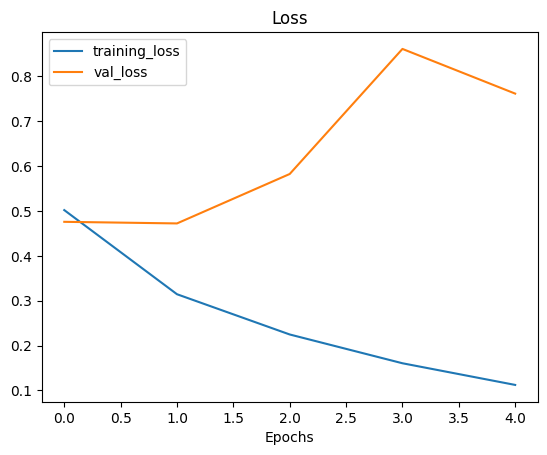

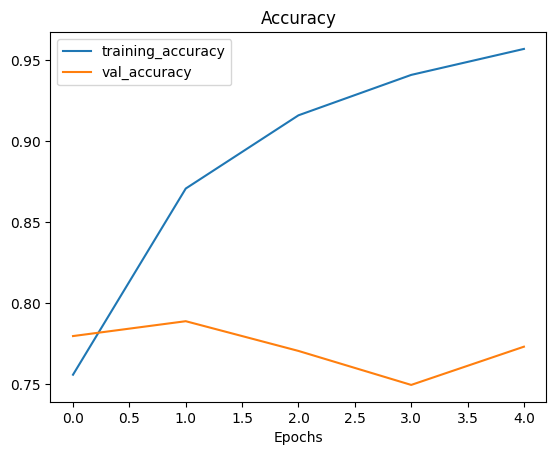

In [ ]:
plot_loss_curves(model_LSTM_history)

Now we've got predicted classes, let's evaluate them against the ground truth labels.

In [ ]:
# Calculate LSTM model results
model_Lstm_results = calculate_results(y_true=val_labels,
                                    y_pred=model_Lstm_prob)
model_Lstm_results

{'accuracy': 77.29658792650919,
 'precision': 0.7753400570774207,
 'recall': 0.7729658792650919,
 'f1': 0.7705764257839071}

#Transfer Learning:-

Process in which pretrained models are used inorder to enhance the accuracy of the mode is the reuse of a pre-trained model on a new problem. In transfer learning, a machine exploits the knowledge gained from a previous task to improve generalization about another.

Here we make use of the pretrained embedding layer **universal-sentence-encoder**

Using the universal sentence encoder a pretrained embedding model from tensorflow_hub.
The input is variable length English text and the output is a 512 dimensional vector.

In [ ]:
import tensorflow_hub as hub
embed=hub.load('https://tfhub.dev/google/universal-sentence-encoder/4')


In [ ]:
sample_embed=embed([random_sentences])
sample_embed

<tf.Tensor: shape=(1, 512), dtype=float32, numpy=
array([[ 6.47219718e-02, -6.33950159e-02,  1.20778196e-02,
        -4.35845330e-02,  1.24159865e-02, -7.37327635e-02,
        -3.17458846e-02, -2.57962570e-02, -2.08438411e-02,
        -8.18180945e-03, -1.37040326e-02,  1.94770657e-02,
        -1.02794906e-02, -2.18163580e-02,  3.92556265e-02,
        -8.36113766e-02,  4.09338810e-02,  1.27428025e-02,
         3.69983763e-02,  3.22636291e-02, -6.18488155e-02,
        -3.39008197e-02,  3.87142673e-02, -5.15656844e-02,
        -1.37637637e-03, -6.51310533e-02,  5.30666262e-02,
        -2.38153413e-02, -5.66348284e-02,  3.59116830e-02,
        -3.63735370e-02, -3.93142030e-02, -2.32904144e-02,
        -5.58060482e-02, -7.91496709e-02, -7.66800568e-02,
         3.45528759e-02,  3.08534559e-02, -2.55636480e-02,
        -4.71706986e-02,  8.35445300e-02, -2.10817251e-02,
        -5.51105700e-02, -6.26134276e-02, -6.55778497e-02,
        -4.69437428e-02,  3.50570045e-02, -7.59988576e-02,
      

In [ ]:
embed_Layer=hub.KerasLayer('https://tfhub.dev/google/universal-sentence-encoder/4',
                           input_shape=[],
                           trainable=False,
                           dtype=tf.string,
                           name="USE")

In [ ]:
model_hub=tf.keras.Sequential([
    embed_Layer, # take in sentences and then encode them into an embedding
    layers.Dense(128,activation='relu'),
    layers.Dense(128,activation='relu'),
    layers.Dense(1,activation='sigmoid')

],name="model_hub")

model_hub.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])

model_hub_history=model_hub.fit(train_sentences,
              train_labels,
              epochs=5,
              validation_data=(val_sentences,val_labels))



Epoch 1/5
215/215 [==============================] - 8s 19ms/step - loss: 0.4691 - accuracy: 0.7859 - val_loss: 0.4316 - val_accuracy: 0.8071
Epoch 2/5
215/215 [==============================] - 3s 12ms/step - loss: 0.3935 - accuracy: 0.8254 - val_loss: 0.4259 - val_accuracy: 0.8123
Epoch 3/5
215/215 [==============================] - 3s 15ms/step - loss: 0.3640 - accuracy: 0.8415 - val_loss: 0.4162 - val_accuracy: 0.8241
Epoch 4/5
215/215 [==============================] - 3s 14ms/step - loss: 0.3292 - accuracy: 0.8626 - val_loss: 0.4299 - val_accuracy: 0.8150
Epoch 5/5
215/215 [==============================] - 3s 12ms/step - loss: 0.2874 - accuracy: 0.8825 - val_loss: 0.4564 - val_accuracy: 0.8110


In [ ]:
model_hub_pred=model_hub.predict(val_sentences)
model_hub_pred=tf.squeeze(tf.round(model_hub_pred))
model_hub_pred

In [ ]:
# Calculate model_hub_results
model_hub_results = calculate_results(y_true=val_labels,
                                    y_pred=model_hub_pred)
model_hub_results

{'accuracy': 81.10236220472441,
 'precision': 0.8120722444527235,
 'recall': 0.8110236220472441,
 'f1': 0.8098976666616808}

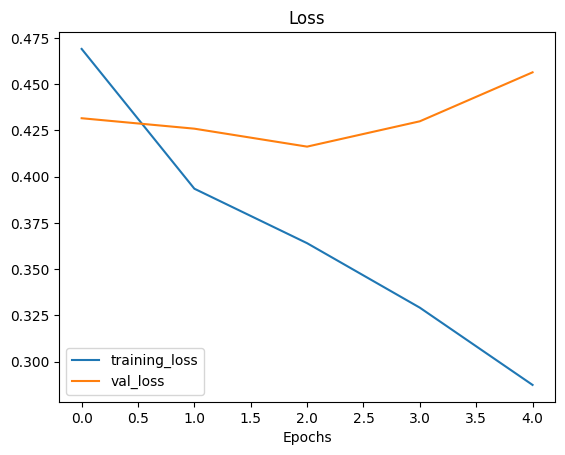

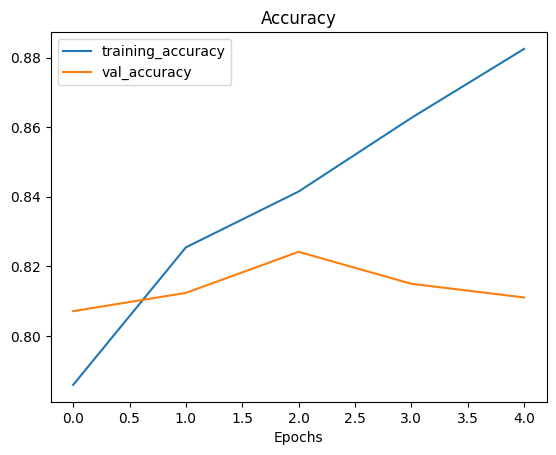

In [ ]:
plot_loss_curves(model_hub_history)


One of the benefits of using transfer learning methods, such as, the pretrained embeddings within the USE is the ability to get great results on a small amount of data

# Key Note:

Transfer Learning works or train finely on small amount of data so we will feed 10% of our train data to the model.
For that we use.sample()function

.sample() is an inbuilt function of random module in Python that returns a particular length list of items chosen from the sequence

In [ ]:
train_10_percent_data=train_df_shuffled[['text','target']].sample(frac=0.1,random_state=42)
train_10_percent_sentences=train_10_percent_data['text'].to_list()
train_10_percent_labels=train_10_percent_data['target'].to_list()


Rather than typing whole model we can use tf.keras.models.clone_model() method to use any model that we have create earlier

In [ ]:
hub_model_clone=tf.keras.models.clone_model(model_hub)
hub_model_clone.compile(loss="binary_crossentropy",
                optimizer=tf.keras.optimizers.Adam(),
                metrics=["accuracy"])
hub_model_clone.fit(train_10_percent_sentences,
                    train_10_percent_labels,
                    epochs=5,
                    validation_data=(val_sentences,val_labels))

Epoch 1/5
24/24 [==============================] - 4s 41ms/step - loss: 0.6611 - accuracy: 0.7070 - val_loss: 0.5838 - val_accuracy: 0.8281
Epoch 2/5
24/24 [==============================] - 1s 22ms/step - loss: 0.5053 - accuracy: 0.8055 - val_loss: 0.4071 - val_accuracy: 0.8228
Epoch 3/5
24/24 [==============================] - 0s 21ms/step - loss: 0.3918 - accuracy: 0.8318 - val_loss: 0.3320 - val_accuracy: 0.8622
Epoch 4/5
24/24 [==============================] - 1s 40ms/step - loss: 0.3235 - accuracy: 0.8620 - val_loss: 0.2754 - val_accuracy: 0.8976
Epoch 5/5
24/24 [==============================] - 1s 48ms/step - loss: 0.2680 - accuracy: 0.8922 - val_loss: 0.2115 - val_accuracy: 0.9304


In [ ]:
hub_model_clone_pred=hub_model_clone.predict(val_sentences)
hub_model_clone_pred=tf.squeeze(tf.round(hub_model_clone_pred))
hub_model_clone_pred_results = calculate_results(y_true=val_labels,
                                    y_pred=hub_model_clone_pred)
hub_model_clone_pred_results


24/24 [==============================] - 1s 9ms/step


{'accuracy': 93.04461942257218,
 'precision': 0.9319387997225046,
 'recall': 0.9304461942257218,
 'f1': 0.9301697352160784}

# Comparision:-

model_hub is train on complete data its results are:-

 {'accuracy': 81.49606299212599,

 'precision': 0.8213263064063367,

 'recall': 0.8149606299212598,

 'f1': 0.8122943055211593}


 hub_model is a clone model of the model_hub but train on 10% of data its results are:-

24/24 [==============================] - 0s 16ms/step
{'accuracy': 92.51968503937007,

 'precision': 0.9263808218304695,

 'recall': 0.9251968503937008,

 'f1': 0.9249294924436201}



# saving model & loading it.

Saving your models also enables you to export them for use elsewhere

outside of your notebooks, such as in a web application.

There are two main ways of saving a model in TensorFlow:

The HDF5 format.

The SavedModel format (default).

In [ ]:
hub_model_clone.save('hub_model_clone.h5')

In [ ]:
from tensorflow_hub.keras_layer import KerasLayer
final_model=tf.keras.models.load_model('hub_model_clone.h5',
                                       custom_objects={"KerasLayer": hub.KerasLayer})

In [ ]:
final_model_pred=final_model.predict(val_sentences)
final_model_pred=tf.squeeze(tf.round(final_model_pred))
final_model_results=calculate_results(y_true=val_labels,
                                    y_pred=final_model_pred)
final_model_results
final_model_pred[:10]


24/24 [==============================] - 1s 9ms/step


<tf.Tensor: shape=(10,), dtype=float32, numpy=array([0., 1., 1., 0., 1., 1., 1., 1., 1., 0.], dtype=float32)>

In [ ]:
final_model.evaluate(val_sentences,val_labels)

24/24 [==============================] - 1s 10ms/step - loss: 0.2115 - accuracy: 0.9304


[0.21151559054851532, 0.930446207523346]

##Making predictions on the test dataset
We don't have labels for the test dataset so we're going to have to make some predictions and inspect them

In [ ]:
test_sentences=test_df['text'].to_list()
random_sentence=random.sample(test_sentences,10) # we will consider any random 10 sentences from the test_sentences.
for random_sentence in random_sentence:
  probability=tf.squeeze((final_model.predict([random_sentence])))# has to be list
  prediction=tf.round(probability)
  print('text:{}'.format(random_sentence))
  print('pred_prob:{}'.format(probability))
  print("prediction:{}".format(prediction))
  print("----\n")



1/1 [==============================] - 0s 38ms/step
text:3 out of the 4 people I'm camping with I would happily see fall of a cliff.
pred_prob:0.15596580505371094
prediction:0.0
----

1/1 [==============================] - 0s 38ms/step
text:#CTA GREEN LINE: All passengers have been evacuated due to a derailment however no service Garfield-Cottage Grove. http://t.co/qePJ0Hwpay
pred_prob:0.9793047308921814
prediction:1.0
----

1/1 [==============================] - 0s 42ms/step
text:Hailstorm cleanup begins in Calgary http://t.co/DhH5jz2w49
pred_prob:0.9171122908592224
prediction:1.0
----

1/1 [==============================] - 0s 39ms/step
text:'I must not fear. Fear is the mind-killer. Fear is the little-death that brings total obliteration... http://t.co/oERI3uWnRY
pred_prob:0.10670613497495651
prediction:0.0
----

1/1 [==============================] - 0s 40ms/step
text:U.S National Park Services Tonto National Forest: Stop the Annihilation of the Salt River Wild Horse... https://t.c

#Create a Function which will load the model and random tweets and will comment whether the tweets is resembling a disaster or not

In [ ]:
def disaster_predictor(model,tweet):
  pred_prob=model.predict([tweet])
  result=tf.squeeze(tf.round(pred_prob)).numpy()
  print("Tweet: {}".format(tweet))
  if result>0:
    print('real disaster')
  elif result<=0:
    print('Not disaster')

In [ ]:
tweet=' Over 110 killed in earthquake: Nepal Home Ministry (PTI)'

In [ ]:
disaster_predictor(final_model,tweet)

1/1 [==============================] - 0s 41ms/step
Tweet:  Over 110 killed in earthquake: Nepal Home Ministry (PTI)
real disaster
